In [32]:
import numpy as np
import pandas as pd
import dabest
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.patches as patches
from PIL import Image
my_color_palette =  {'Dz 1mg/kg':'#663399','Dz 3mg/kg':'#4AB2D6','Dz 5mg/kg':'#8FB996','Dz 7mg/kg':'#006594','NaCl':'#594157', 'PTZ 20mg/kg':'#c7991a'}

In [57]:
# Load data (all responses to single pulse across channels and sessions)
All_SP_df = pd.read_pickle('Mice_data/All_SP_df')
conditions = ['NaCl', 'Dz 7mg/kg','Dz 5mg/kg','Dz 3mg/kg','Dz 1mg/kg','PTZ 20mg/kg']
channel_order = ["ENT R ventral", "ENT R dorsal", "CA1 R", "CA3 R", "DG R","Sub R", "CA3 L","CA1 L", "DG L","Sub L", "ENT L dorsal", "ENT L ventral"]

                Filename  Condition  Intensity[v]        Channel  \
278     Ent_CamK2_03_S02  Dz 5mg/kg           1.0  ENT R ventral   
281     Ent_CamK2_03_S02  Dz 5mg/kg           1.0  ENT R ventral   
286     Ent_CamK2_03_S02  Dz 5mg/kg           1.0  ENT R ventral   
287     Ent_CamK2_03_S02  Dz 5mg/kg           1.0  ENT R ventral   
306     Ent_CamK2_03_S02  Dz 5mg/kg           1.0  ENT R ventral   
...                  ...        ...           ...            ...   
383895  Ent_CamK2_58_S14  Dz 5mg/kg           1.0   ENT L dorsal   
383898  Ent_CamK2_58_S14  Dz 5mg/kg           1.0   ENT L dorsal   
383906  Ent_CamK2_58_S14  Dz 5mg/kg           1.0   ENT L dorsal   
383918  Ent_CamK2_58_S14  Dz 5mg/kg           1.0   ENT L dorsal   
383921  Ent_CamK2_58_S14  Dz 5mg/kg           1.0   ENT L dorsal   

        Sum LL 250ms  Normalized Sum LL 250ms  
278         4.159299                 0.969602  
281         3.762598                 0.877125  
286         4.213095                 0.

In [58]:
# Arrange data both by channel and pharmacological condition (CND)
All_SP_df['Condition'] = pd.Categorical(All_SP_df.Condition.tolist(), categories=conditions)
All_SP_df['Channel'] = pd.Categorical(All_SP_df.Channel.tolist(), categories=channel_order)
All_SP_df.sort_values(by=['Channel', 'Condition'], inplace=True)
All_SP_df['Channel x CND'] = All_SP_df['Channel'].astype(str) + ' ' + All_SP_df['Condition'].astype(str)

def nest_list(flat_list, nesting_factor):
    i = 0
    nested_list = []
    while i < len(flat_list):
        nested_list.append(flat_list[i:i + nesting_factor])
        i += nesting_factor

    return nested_list

all_condition = All_SP_df['Channel x CND'].unique()
all_condition_nested = nest_list(all_condition.tolist(), len(conditions))

In [59]:
# Calculate the mean difference after bootstrapping for each channel and each pharmacological condition
multi_groupe = dabest.load(All_SP_df, idx=all_condition_nested, x='Channel x CND', y='Normalized Sum LL 250ms', resamples=5000)
result_Bootstrap = multi_groupe.mean_diff.statistical_tests

In [60]:
# Extract the result from result_Bootstrap
conditions_mean_diff =  np.delete(conditions, 0) # Remove the control conditions
df_by_cnd = []
for i_cnd, cnd in enumerate(conditions_mean_diff):
    mean_diff = result_Bootstrap["difference"][i_cnd::len(conditions_mean_diff)]
    IC_95= result_Bootstrap["bca_high"][i_cnd::len(conditions_mean_diff)]
    IC_05 = result_Bootstrap["bca_low"][i_cnd::len(conditions_mean_diff)]
    p_value = result_Bootstrap["pvalue_permutation"][i_cnd::len(conditions_mean_diff)]
    value_df = {'Channel': channel_order,'Condition': [cnd] * len(mean_diff),'Mean Diff': mean_diff, 'IC 95': IC_95 , 'IC 05':IC_05, 'p_value perm': p_value}
    df_Cnd = pd.DataFrame(value_df,columns=['Channel','Condition', 'Mean Diff', 'IC 95', 'IC 05', 'p_value perm'])
    df_by_cnd.append(df_Cnd)
df_all_cnd = pd.concat(df_by_cnd, ignore_index=True)
#print(df_all_cnd)

/var/folders/6r/0p67bvdn7t75cb5rwnqb9qdr0000gn/T/ipykernel_66334/1187882646.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('seismic')


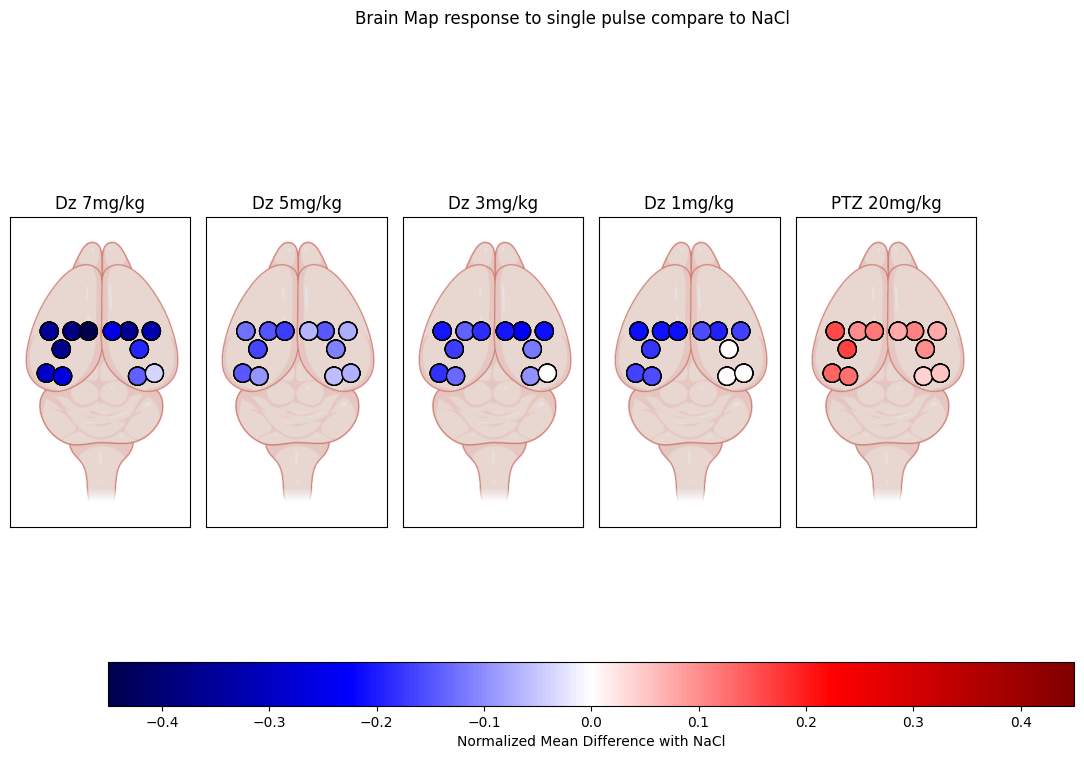

In [61]:
title = 'Brain Map of response to single pulse compare to NaCl'
im = Image.open('Mice_data/Brain_axial.png') #load the brain image as tempalte
# Patch coordinate on the the brain image
Corr_patch = { "ENT R ventral" :(212,265),"ENT R dorsal" :(240,260),'CA1 R': (197, 190) , 'DG R':(170, 190) ,'CA3 R':(235, 190), "Sub R":(215, 220),"CA3 L": (65, 190), "CA1 L":(103, 190), "DG L":(130, 190),"Sub L":(85, 220),
                    "ENT L ventral":(87,265), "ENT L dorsal":(60,260)}

fig2 = plt.figure(title, figsize=(15, 8)).suptitle(title)
gridspec.GridSpec(12, 12)
col_cnd = int(12 / len(conditions_mean_diff))
divnorm = colors.TwoSlopeNorm(vmin=-0.45, vcenter=0,vmax=0.45)
cmap = mpl.cm.get_cmap('seismic')

for i, cnd in enumerate(conditions_mean_diff):
    ax = plt.subplot2grid((12, 12), (0, i*col_cnd), rowspan=11, colspan=col_cnd)
    ax.set_title(cnd)
    ax.imshow(im)  # Display the brain image
    ax.set_xticks([])
    ax.set_yticks([])

    # Create a Circle patch for each brain region
    all_patches=[]
    for Channel in df_all_cnd['Channel']:
        Value = float(df_all_cnd['Mean Diff'][(df_all_cnd['Channel']==Channel) & (df_all_cnd['Condition']==cnd)])
        p_value = float(df_all_cnd['p_value perm'][(df_all_cnd['Channel']==Channel) & (df_all_cnd['Condition']==cnd)])
        if p_value > 0.005: # values within 95% confidence intervals are left blank
            Value = 0
        coor = Corr_patch[Channel]
        color=cmap(divnorm(Value))
        cir =  patches.Circle(coor, radius=15, edgecolor='k', facecolor=color)
        all_patches.append(cir)

    for patch in all_patches:
        ax.add_patch(patch)

ax1 =  plt.subplot2grid((12, 12), (11, 1), rowspan=1, colspan=10)
colorbar = mpl.colorbar.ColorbarBase(ax1, orientation='horizontal',cmap=cmap,norm=divnorm, label='Normalized Mean Difference with NaCl')